In [12]:
import torch
import torch.nn as nn  # nn module
import torch.optim as optim  # optimizers
import torch.nn.functional as F  #activation functions
from torch.utils.data import DataLoader  #create mini batches
import torchvision.datasets as datasets  # MNIST
import torchvision.transforms as transforms  # transformations on datasets
import matplotlib.pyplot as plt  # for visualization

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:

class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):  # in_channels = 1 because grayscale
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.bn1 = nn.BatchNorm2d(16)  # Batch Normalization
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.bn2 = nn.BatchNorm2d(32)  # Batch Normalization
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.bn3 = nn.BatchNorm2d(64)  # Batch Normalization
        
        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)  # Increased dropout rate

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 3 * 3, 256)  # Increased number of neurons
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)

        # Flatten the tensor for the fully connected layers
        x = x.view(x.shape[0], -1)  # Flatten the output

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x


In [14]:
model = CNN().to(device)

# Hyperparameters
in_channels = 1
learning_rate = 0.0006
batch_size = 64
num_epochs = 20  # Increased for better training

# Data transformations with augmentation
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, saturation, and hue
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Randomly translate the image
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5, interpolation=3),  # Apply random perspective transformation
    transforms.RandomResizedCrop(size=28, scale=(0.8, 1.0)),  # Randomly resize and crop
    transforms.ToTensor()
])


train_dataset = datasets.MNIST(root='dataset/', train=True, download=True, transform=train_transforms)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='dataset/', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [16]:
def accuracy(loader, model):
    model.eval()  #Set the model to evaluation mode implies no dropout or batch norm
    num_correct = 0
    num_samples = 0

    with torch.no_grad():  # No gradient calculation for evaluation
        for x, y in loader:
            x, y = x.to(device), y.to(device)  #Move data to the device
            scores = model(x) #scores.shape = (batch_size, num_classes)
            _, predictions = scores.max(1)  #Gets the index of the  class with the highest score and we ignore the maximum value 
            num_correct += (predictions == y).sum().item()#correct predictions
            num_samples += predictions.size(0)#total predictions

    accuracy = float(num_correct) / num_samples * 100
    return accuracy

In [ ]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode enables batch_norm 
    running_loss = 0.0

    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()
        scores = model(data)
        loss = criterion(scores, targets)
        loss.backward() #computes the gradients 
        optimizer.step() #updates the model parameters 

        running_loss += loss.item()

    # Calculate average training loss
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on training and test set
    train_accuracy = accuracy(train_loader, model)
    test_accuracy = accuracy(test_loader, model)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')
    torch.save(model.state_dict(), "digit_recognizer_model.pth")

Epoch [1/20], Loss: 0.5590, Train Acc: 88.42%, Test Acc: 92.21%
Epoch [2/20], Loss: 0.2411, Train Acc: 95.28%, Test Acc: 97.10%
Epoch [3/20], Loss: 0.1889, Train Acc: 95.79%, Test Acc: 97.77%
Epoch [4/20], Loss: 0.1640, Train Acc: 96.41%, Test Acc: 97.94%
Epoch [5/20], Loss: 0.1467, Train Acc: 96.79%, Test Acc: 98.18%
Epoch [6/20], Loss: 0.1372, Train Acc: 96.93%, Test Acc: 98.36%
Epoch [7/20], Loss: 0.1276, Train Acc: 96.98%, Test Acc: 98.33%
Epoch [8/20], Loss: 0.1218, Train Acc: 97.32%, Test Acc: 98.38%
Epoch [9/20], Loss: 0.1120, Train Acc: 97.42%, Test Acc: 98.57%
Epoch [10/20], Loss: 0.1113, Train Acc: 97.44%, Test Acc: 98.57%
Epoch [11/20], Loss: 0.1038, Train Acc: 97.60%, Test Acc: 98.83%
Epoch [12/20], Loss: 0.1028, Train Acc: 97.78%, Test Acc: 98.78%


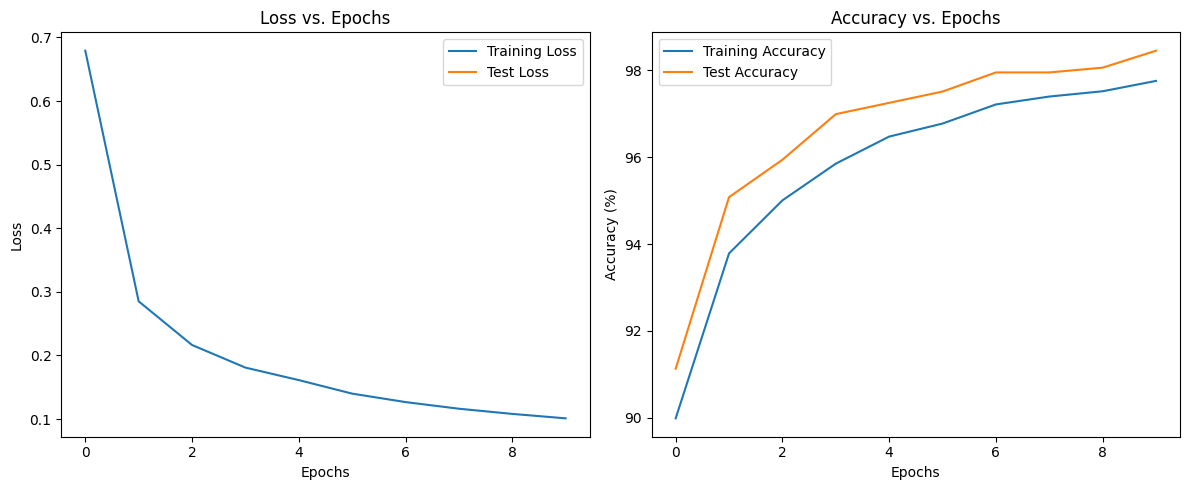

In [8]:
plt.figure(figsize=(12, 5))

# Loss vs. Epochs
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy vs. Epochs
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

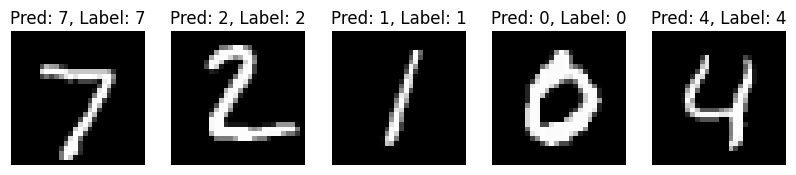

In [11]:
def visualize_images(loader, model, num_images=5):
    model.eval()
    images, labels = next(iter(loader))

    with torch.no_grad():
        outputs = model(images)
        _, preds = outputs.max(1)

    # Set up the plot
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f'True: {labels[i]} Pred: {preds[i]}')
        plt.axis('off')
    plt.show()# %% [code]
def visualize_images(loader, model, num_images=5):
    model.eval()  # Set the model to evaluation mode
    images, labels = next(iter(loader))
    
    images = images.to(device)  # Move images to the appropriate device (CPU or GPU)
    labels = labels.to(device)  # Move labels to the appropriate device (CPU or GPU)

    with torch.no_grad():
        outputs = model(images)
        _, preds = outputs.max(1)

    # Set up the plot
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')  # Move images back to CPU for plotting
        plt.title(f'Pred: {preds[i].item()}, Label: {labels[i].item()}')
        plt.axis('off')
    plt.show()

# Call the visualization function after training to see the predictions
visualize_images(test_loader, model)


